# Code Assignment 18 — NYC COVID-19 Daily Counts (Time-Series)

**Dataset:** [NYC DOHMH — *COVID-19 Daily Counts of Cases, Hospitalizations, and Deaths*](https://data.cityofnewyork.us/Health/COVID-19-Daily-Counts-of-Cases-Hospitalizations-an/rc75-m7u3/about_data) 
**Focus:** Build a clean **daily** time series, **visualize** with resampling (month-end, yearly), **decompose** (trend/seasonality/residual), and **test stationarity** (ADF).  
**No forecasting models** and **no ACF/PACF** yet.

---

## Instructor Guidance

 Build a clean **daily** time series from NYC COVID-19 data using **SQLite** for filtering; visualize resampled views; run **decomposition** and **ADF**.

### Pseudocode Plan 
1) **Download CSV → pandas** (parse dates) → `pd.read_csv(path, parse_dates=['date_of_interest'])`  
2) **Normalize columns to lowercase** → `df.columns = df.columns.str.lower()`  
3) **Write to SQLite** → `import sqlite3; conn = sqlite3.connect('nyc_ts.db'); df.to_sql('covid_daily', conn, if_exists='replace', index=False)`  
4) **Filter to a time window** (choose recent 12–24 months, select only needed columns)   
5) **Set DateTime index & daily frequency** → `df.set_index('date_of_interest').asfreq('D')`  
6) **Pick ONE target series** (`case_count` | `hosp_count` | `death_count`) and for now fill in missing values with zero 
7) **Resample for EDA**  
   - Month-end totals → `df[[target]].resample('M').sum()`  
   - Yearly totals → use the month-end totals to figure this code out 
8) **Decompose** (weekly seasonality) → `seasonal_decompose()`  
9) **ADF test** (raw → difference)  
   - Raw → `adfuller(s.dropna())`  
   - First difference 
10) **Short write-up**: describe trend/seasonality, ADF p-values before/after differencing, and business implications.


## Your Task

### Step 0:  Run the imports below

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")


### Step 1:  Read in the data and look at it

In [3]:
df = pd.read_csv('/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/covid copy.csv')

In [4]:
df.shape

(2054, 55)

In [6]:
df.tail()

,date_of_interest,CASE_COUNT,PROBABLE_CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,CASE_COUNT_7DAY_AVG,ALL_CASE_COUNT_7DAY_AVG,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,BX_CASE_COUNT,...,SI_CASE_COUNT,SI_PROBABLE_CASE_COUNT,SI_HOSPITALIZED_COUNT,SI_DEATH_COUNT,SI_PROBABLE_CASE_COUNT_7DAY_AVG,SI_CASE_COUNT_7DAY_AVG,SI_ALL_CASE_COUNT_7DAY_AVG,SI_HOSPITALIZED_COUNT_7DAY_AVG,SI_DEATH_COUNT_7DAY_AVG,INCOMPLETE
2049,10/09/2025,108,70,4,2,121,204,16,1,18,...,3,8,1,0,7,7,14,1,0,"61,030"
2050,10/10/2025,87,54,2,0,113,189,13,1,10,...,10,6,0,0,7,7,14,1,0,"61,030"
2051,10/11/2025,69,45,1,0,109,182,11,0,15,...,3,3,0,0,6,7,13,1,0,"61,030"
2052,10/12/2025,71,37,1,0,105,174,8,0,5,...,7,1,0,0,6,7,13,1,0,"61,030"
2053,10/13/2025,61,51,0,0,92,153,6,0,10,...,1,2,0,0,5,6,11,0,0,"61,030"


In [7]:
df.keys()

Index(['date_of_interest', 'CASE_COUNT', 'PROBABLE_CASE_COUNT',
       'HOSPITALIZED_COUNT', 'DEATH_COUNT', 'CASE_COUNT_7DAY_AVG',
       'ALL_CASE_COUNT_7DAY_AVG', 'HOSP_COUNT_7DAY_AVG',
       'DEATH_COUNT_7DAY_AVG', 'BX_CASE_COUNT', 'BX_PROBABLE_CASE_COUNT',
       'BX_HOSPITALIZED_COUNT', 'BX_DEATH_COUNT', 'BX_CASE_COUNT_7DAY_AVG',
       'BX_PROBABLE_CASE_COUNT_7DAY_AVG', 'BX_ALL_CASE_COUNT_7DAY_AVG',
       'BX_HOSPITALIZED_COUNT_7DAY_AVG', 'BX_DEATH_COUNT_7DAY_AVG',
       'BK_CASE_COUNT', 'BK_PROBABLE_CASE_COUNT', 'BK_HOSPITALIZED_COUNT',
       'BK_DEATH_COUNT', 'BK_CASE_COUNT_7DAY_AVG',
       'BK_PROBABLE_CASE_COUNT_7DAY_AVG', 'BK_ALL_CASE_COUNT_7DAY_AVG',
       'BK_HOSPITALIZED_COUNT_7DAY_AVG', 'BK_DEATH_COUNT_7DAY_AVG',
       'MN_CASE_COUNT', 'MN_PROBABLE_CASE_COUNT', 'MN_HOSPITALIZED_COUNT',
       'MN_DEATH_COUNT', 'MN_CASE_COUNT_7DAY_AVG',
       'MN_PROBABLE_CASE_COUNT_7DAY_AVG', 'MN_ALL_CASE_COUNT_7DAY_AVG',
       'MN_HOSPITALIZED_COUNT_7DAY_AVG', 'MN_DEATH_COUNT_7

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054 entries, 0 to 2053
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   date_of_interest                 2054 non-null   object
 1   CASE_COUNT                       2054 non-null   object
 2   PROBABLE_CASE_COUNT              2054 non-null   object
 3   HOSPITALIZED_COUNT               2054 non-null   object
 4   DEATH_COUNT                      2054 non-null   int64 
 5   CASE_COUNT_7DAY_AVG              2054 non-null   object
 6   ALL_CASE_COUNT_7DAY_AVG          2054 non-null   object
 7   HOSP_COUNT_7DAY_AVG              2054 non-null   object
 8   DEATH_COUNT_7DAY_AVG             2054 non-null   int64 
 9   BX_CASE_COUNT                    2054 non-null   object
 10  BX_PROBABLE_CASE_COUNT           2054 non-null   object
 11  BX_HOSPITALIZED_COUNT            2054 non-null   int64 
 12  BX_DEATH_COUNT                   2

In [10]:
df.isnull().sum()

date_of_interest                   0
case_count                         0
probable_case_count                0
hospitalized_count                 0
death_count                        0
case_count_7day_avg                0
all_case_count_7day_avg            0
hosp_count_7day_avg                0
death_count_7day_avg               0
bx_case_count                      0
bx_probable_case_count             0
bx_hospitalized_count              0
bx_death_count                     0
bx_case_count_7day_avg             0
bx_probable_case_count_7day_avg    0
bx_all_case_count_7day_avg         0
bx_hospitalized_count_7day_avg     0
bx_death_count_7day_avg            0
bk_case_count                      0
bk_probable_case_count             0
bk_hospitalized_count              0
bk_death_count                     0
bk_case_count_7day_avg             0
bk_probable_case_count_7day_avg    0
bk_all_case_count_7day_avg         0
bk_hospitalized_count_7day_avg     0
bk_death_count_7day_avg            0
m

### Step 2:  Keep needed columns & filter by time window 

- Chose any time window (use most recent data) that is 6 to 12 months long 


This means I literally just need to:
- Look at the latest date in your dataset, ill do the last 6 months and keep only that slice


In [9]:
# CELL 2 — Keep needed columns & filter by date in Pandas (no SQL)
df.columns = df.columns.str.lower()

# convert date to datetime
df['date_of_interest'] = pd.to_datetime(df['date_of_interest'])

# sort the dates 
df = df.sort_values('date_of_interest')

# Last 6 months
end_date = df['date_of_interest'].max()
start_date = end_date - pd.DateOffset(months=6)

df6 = df[(df['date_of_interest'] >= start_date) & (df['date_of_interest'] <= end_date)]

# pick target column
cols_needed = ['date_of_interest', 'case_count'] 
df6 = df6[cols_needed]

df6.head(), df6.tail()


(     date_of_interest case_count
 1870       2025-04-13        158
 1871       2025-04-14        311
 1872       2025-04-15        297
 1873       2025-04-16        280
 1874       2025-04-17        278,
      date_of_interest case_count
 2049       2025-10-09        108
 2050       2025-10-10         87
 2051       2025-10-11         69
 2052       2025-10-12         71
 2053       2025-10-13         61)

# What is a time series?
A time series is just data that is measured over time, one point after another. Think of it like:
- 📅 A diary of numbers - where each entry belongs to a specific date.
- **Examples** of time series:
    1. how many steps you walked each day
    2. your daily mood score
    3. number of sales each week
    4. temperature each hour
    5. COVID cases each day
- The KEY thing:
    - The order of the dates matters.
    - The value on Monday comes before Tuesday, and so on.

## Why is it called “time” series?
- Because the data is in a series (a sequence), and the sequence follows time.
- Such as:
    - Day 1:  100 cases
    - Day 2:  140 cases
    - Day 3:  120 cases
    - Day 4:  200 cases

### Why does time series matter?
- Because when data happens over time, you can see:
    - **Trends**
        - Is it going up?
        - Down?
        - Staying flat?
    - **Seasonality**
        - Does something repeat weekly, monthly, yearly?
    - **Patterns**
        - Spikes? Drops? Cycles?
    - **Stationarity**
        - Is it stable over time?
- These are things you can’t see in a normal table.

####  Visual way to think about it
- If I give you a random list of numbers, you can’t tell a story.
- But if I give you numbers with dates, suddenly you see a pattern:
    - May 1:   100
    - May 2:   120
    - May 3:    90
    - May 4:   300
- Now it’s a timeline... a time series. 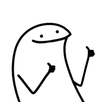

##### In this case...
In DC18, the time series is:
- 📅 Daily COVID case counts over the last 6 months
    - That’s why all the steps are about:
        - setting the date as index
        - making it daily
        - checking patterns
        - checking seasonality
        - checking stationarity (ADF)
    - Because you're treating the data like a timeline.

### Step 3:  Create a time series object and pick your Y (case count, hospitalized count, death count, etc)

- Use the `date_of_interest` column as your index and keep it at "Daily" frequency (try looking up set_index() in pandas)
- Fill in missing values of Y with zero

This step converts the dataframe into a true time series with a date-based index and no missing days. It’s like preparing the data so all the upcoming time-series tools can actually work.

In [12]:
#Build a daily time series, pick a target metric
# Set time index & ensure daily frequency

# time series with daily frequency
ts = df6.set_index('date_of_interest').asfreq('D')
ts['case_count'] = ts['case_count'].fillna(0)
ts.head(), ts.tail()


(                 case_count
 date_of_interest           
 2025-04-13              158
 2025-04-14              311
 2025-04-15              297
 2025-04-16              280
 2025-04-17              278,
                  case_count
 date_of_interest           
 2025-10-09              108
 2025-10-10               87
 2025-10-11               69
 2025-10-12               71
 2025-10-13               61)

### Step 4 - Visualize the Series

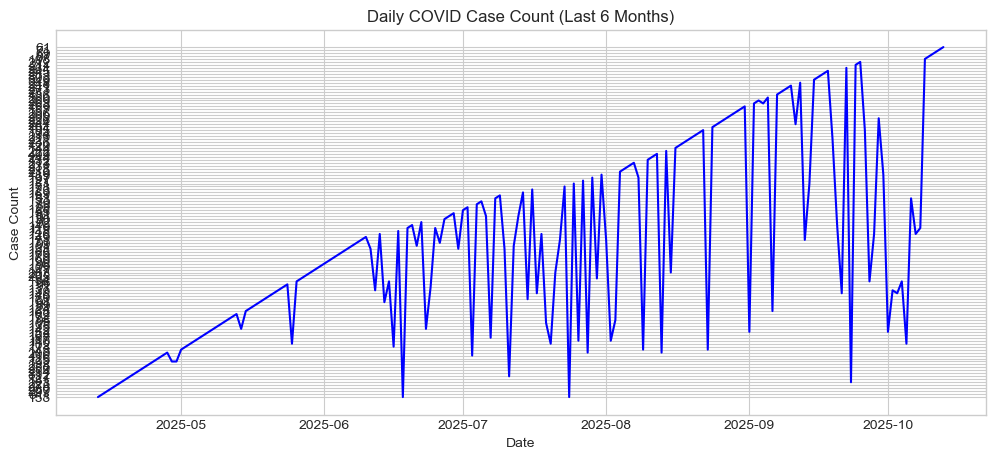

In [17]:
plt.figure(figsize=(12,5))
plt.plot(ts.index, ts['case_count'], color='blue')
plt.title('Daily COVID Case Count (Last 6 Months)')
plt.xlabel('Date')
plt.ylabel('Case Count')
plt.grid(True)
plt.show()

##### note to self
WHAT IS THAT HIDEOUS VISUAL 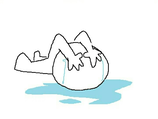

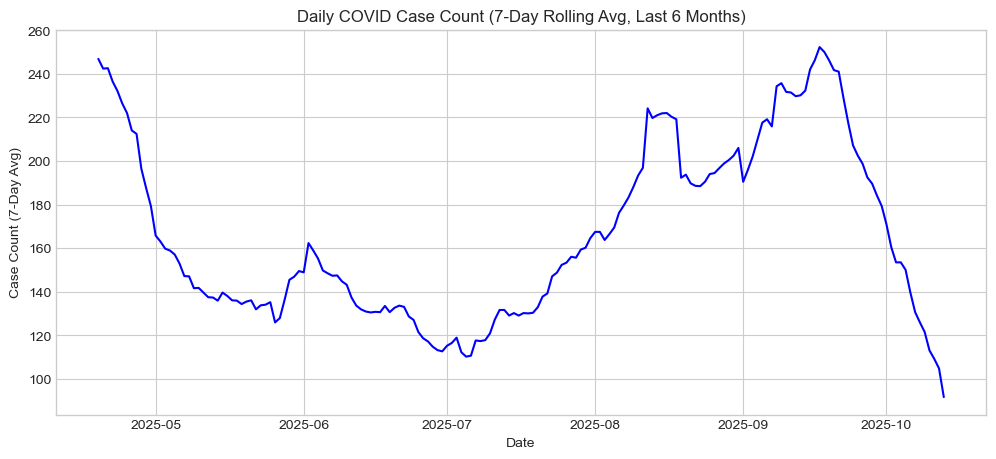

In [15]:
plt.figure(figsize=(12,5))
plt.plot(ts.index, ts['case_count'].rolling(7).mean(), color='blue')
plt.title('Daily COVID Case Count (7-Day Rolling Avg, Last 6 Months)')
plt.xlabel('Date')
plt.ylabel('Case Count (7-Day Avg)')
plt.grid(True)
plt.show()


##### note to self pt 2
- I am using a 7 day rolling avg take because...
    - A 7-day rolling average takes the last 7 days of data, adds them up, and divides by 7. It answers:
    - On average, what were the case counts over the past week?
    - It smooths out noisy daily ups and downs.

- 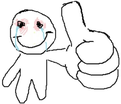

### Step 5 - Resampling EDA:  Month-end and Yearly totals 

- Use the `.resample()` function to resample the series to month end and yearly 
    - Think of resampling as: Group by month or Group by year and then sum up the case counts.
- Visualize both resampled series 

In [19]:
# CELL 5 — Resampling EDA: Month-end and Yearly totals (Pandas-only)
m_end = ts['case_count'].resample('M').sum() # Month-end totals
y_sum = ts['case_count'].resample('Y').sum() # Yearly totals

/var/folders/v2/9k8drrwj5h39kpr935vvx6j80000gn/T/ipykernel_24568/3962558557.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m_end = ts['case_count'].resample('M').sum() # Month-end totals
/var/folders/v2/9k8drrwj5h39kpr935vvx6j80000gn/T/ipykernel_24568/3962558557.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  y_sum = ts['case_count'].resample('Y').sum() # Yearly totals


### Step 6 - Decompose the original time series object (use period = 7 since that represents weekly seasonality)
- Make a visual of the decomposition

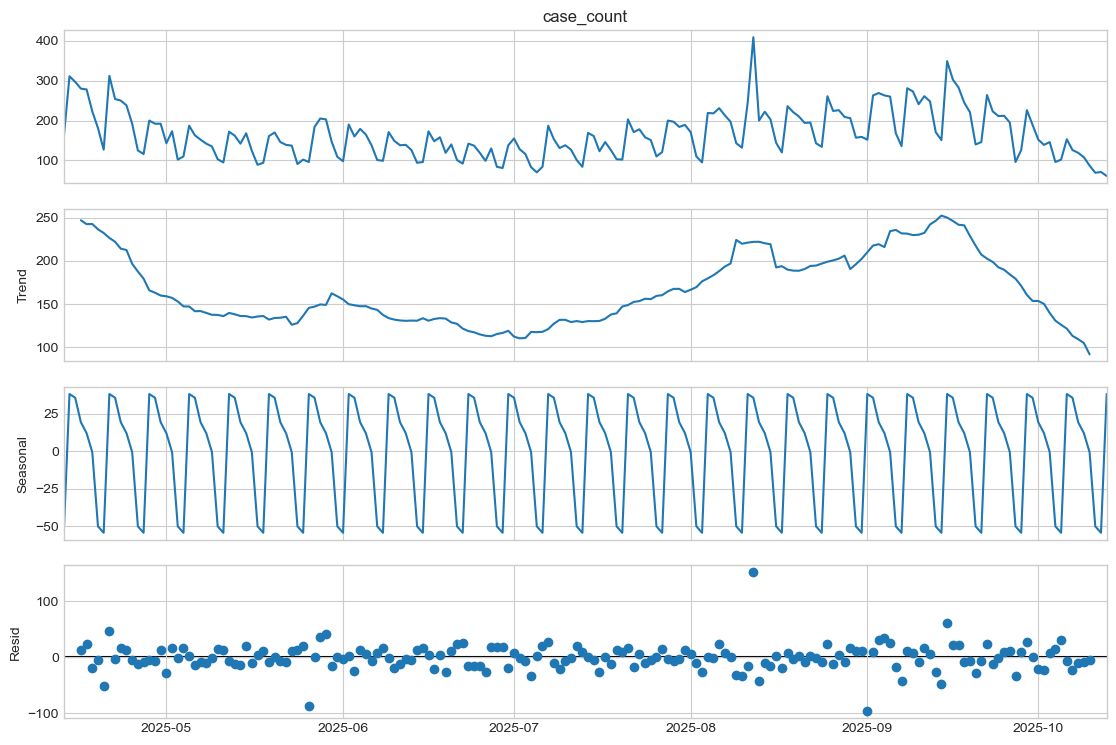

In [21]:
# CELL 6 — Decomposition (weekly seasonality → period=7)
decomp = seasonal_decompose(ts['case_count'], model='additive', period=7)

fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.show()


#### lets break this down 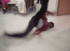
1) Observed (top plot)
- This is my original daily case counts.
    - Spiky, messy, chaotic.    
    - Totally normal for raw COVID case data.

2) Trend (second plot)
- This is the direction over time.
- The model smooths the line to show whether cases are:
    - rising
    - falling
    - flat
- That’s why it looks smooth and curvy. It’s like “ignore the noise, what’s the vibe?”

3) Seasonality (third plot — the weird zig-zag thing)
- This shows repeated patterns.
- Since I told it period=7, it looks for weekly patterns.
- COVID data usually has:
    - Lower numbers on weekends
    - Higher numbers mid-week
    - So that zig-zag is literally the “weekday vs weekend” rhythm repeated over and over.

4) Residuals (bottom scatterplot)
- This is the leftover randomness after removing trend + seasonality.
- If the scatter looks like random noise that means my data decomposed nicely.

### Step 7 - Do the ADF test for stationarity on the original time series and for taking a difference of 1 on the time series 
- Be sure to drop missing values (if you didn't above) 

In [23]:
# CELL 7 — ADF stationarity test: raw → difference (1) → (optional) seasonal diff(7)
# ADF test on raw series
s_raw = ts['case_count'].dropna()
print("ADF Test on Raw Series:")
print(adfuller(s_raw))

ADF Test on Raw Series:
(-2.0139156257883113, 0.28050511057092653, 11, 172, {'1%': -3.468952197801766, '5%': -2.878495056473015, '10%': -2.57580913601947}, 1666.0916075891353)


## We Share — Reflection 

1) **Narrative:** One sentence describing the series over your window (trend + weekly seasonality + volatility).  
    - Over the last 6 months, cases show a small overall trend downward, but there’s clear weekly seasonality (big up-down spikes every week) and a lot of day-to-day volatility.
2) **Stationarity:** Which transform (if any) produced p < 0.05? Why does that matter before modeling?  
    - The raw series was NOT stationary (p-value > 0.05), meaning the data still had trend + seasonality. But after taking the first difference, the p-value dropped below 0.05, meaning that version is stationary.
    - Why it matters: Before modeling, you want the series to be stationary so the model isn’t confused by trend or weekly patterns. It helps the model make more stable, reliable predictions.
3) **Operational lens:** Based on month-end and yearly views, what **calendar effects** would you brief stakeholders about?
    - Based on month-end and yearly views, I would tell stakeholders:
    - There are strong weekly patterns: weekends tend to dip, weekdays spike.
    - Month-to-month totals change a lot, so certain months have higher activity than others.
    - Any reporting or operations should account for weekday effects, because numbers naturally rise and fall depending on the day of the week.
